<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Lesson 12: Predicting Evergreeness of Content with Decision Trees and Random Forests

---

## Load the StumbleUpon dataset

We will be using a dataset from StumbleUpon, a service that recommends webpages to users based on their interests.  They like to recommend “evergreen” sites, sites that are always relevant.  This usually means websites that avoid topical content and focus on recipes, how-to guides, art projects, etc.  We want to determine important characteristics for “evergreen” websites. Follow these prompts to get started:


In [1]:
import pandas as pd
import json

data = pd.read_csv("../dataset/stumbleupon.tsv", sep='\t')
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))
data.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,24,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,40,0,4973,187,9,0.181818,0.125448,1,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,55,0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,24,0,2737,120,5,0.041667,0.100858,1,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,14,0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...


## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender. A description of the columns is below:

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?

> #### Evergreen sites are those that are always relevant.  As opposed to breaking news or current events, evergreen websites are relevant no matter the time or season. 

> #### A sample of URLs is below, where label = 1 are 'evergreen' websites

In [2]:
data[['url', 'label']].head()

,url,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,0
1,http://www.popsci.com/technology/article/2012-...,1
2,http://www.menshealth.com/health/flu-fighting-...,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,1
4,http://bleacherreport.com/articles/1205138-the...,0


### Exercises to Get Started

 ### Exercise: 1. In a group: Brainstorm 3 - 5 features you could develop that would be useful for predicting evergreen websites.
 ###  Exercise: 2. After looking at the dataset, can you model or quantify any of the characteristics you wanted?
- I.E. If you believe high-image content websites are likely to be evergreen, how can you build a feature that represents that?
- I.E. If you believe weather content is likely NOT to be evergreen, how might you build a feature that represents that?

### Split up and develop 1-3 of those features independently.

### Exercise: 3. Does being a news site affect evergreeness? 
Compute or plot the percentage of news related evergreen sites.

In [3]:
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# Option 1: Find out P ( evergreen | is_news = 1) vs P ( evergreen | is_news = ?)

data.groupby(['is_news'])[['label']].mean()

,label
is_news,
1,0.516916
?,0.507562


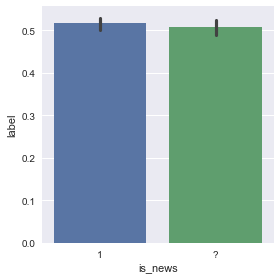

In [4]:
##  OR

sb.factorplot(x='is_news', 
              y='label',
              kind='bar',
              data = data)
plt.show()

### Exercise: 4. Does category in general affect evergreeness? 
Plot the rate of evergreen sites for all Alchemy categories.

In [5]:
category_means = data.groupby(['alchemy_category'])[['label']].mean().sort_values(
    by='label',ascending=False)
category_means

,label
alchemy_category,
business,0.711364
recreation,0.684296
health,0.573123
?,0.502135
culture_politics,0.457726
science_technology,0.456747
law_crime,0.419355
religion,0.416667
arts_entertainment,0.371945


In [6]:
categories_ordered = list(category_means.index.values)

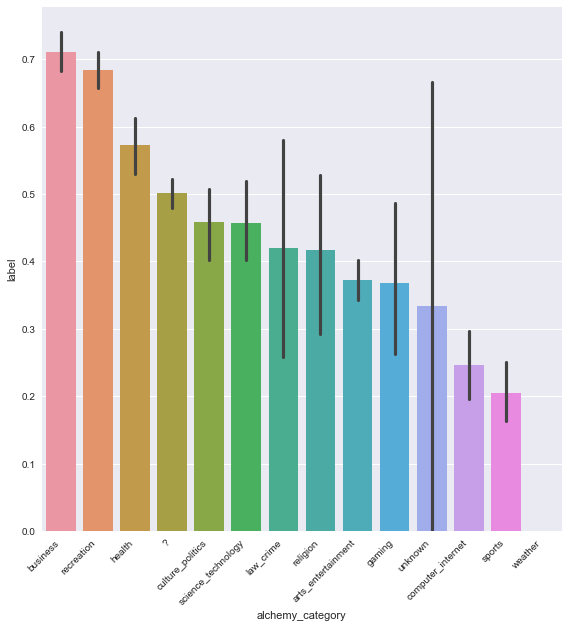

In [7]:
p = sb.factorplot(x='alchemy_category', 
                  y='label',
                  kind='bar',
                  data = data,
                  size = 8,
                  order = categories_ordered
            )
p.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

### Exercise: 5. How many articles are there per category?

In [8]:
category_counts = data.groupby(['alchemy_category'])[['label']].count().sort_values(
    by='label',ascending=False)
category_counts

,label
alchemy_category,
?,2342
recreation,1229
arts_entertainment,941
business,880
health,506
sports,380
culture_politics,343
computer_internet,296
science_technology,289


In [9]:
categories_ordered_count = list(category_counts.index.values)

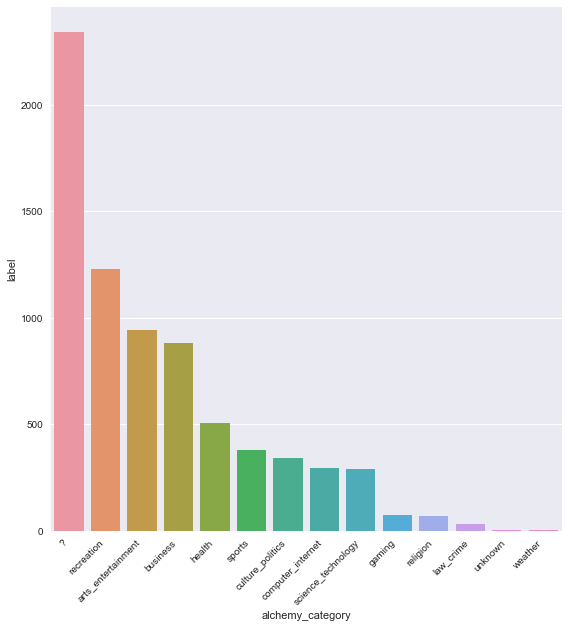

In [10]:
p = sb.factorplot(x = 'alchemy_category', 
              y = 'label',
              kind = 'bar',
              data = data,
              size = 8,
              estimator = len,
            order = categories_ordered_count
            )
p.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

> #### Let's try extracting some of the text content.
> ### Exercise: 6. Create a feature for the title containing 'recipe'. 
Is the % of evergreen websites higher or lower on pages that have recipe in the title?

In [11]:
# Option 1: Create a function to check for this

def has_recipe(text_in):
    try:
        if 'recipe' in str(text_in).lower():
            return 1
        else:
            return 0
    except: 
        return 0
        
#data['recipe'] = data['title'].map(has_recipe)

# Option 2: lambda functions

#data['recipe'] = data['title'].map(lambda t: 1 if 'recipe' in str(t).lower() else 0)


# Option 3: string functions
data['recipe'] = data['title'].str.contains('recipe')

In [12]:
data['recipe'].value_counts()

False    7030
True      353
Name: recipe, dtype: int64

###  Let's Explore Some Decision Trees

 ### Demo: Build a decision tree model to predict the "evergreeness" of a given website. 

In [13]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=2)

X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)
    
    
# Fits the model
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [14]:
# REQUIREMENTS:
# pip install pydotplus

# Not needed but useful for decision tree plotting:
# pip install graphviz
# brew install graphviz

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# initialize the output file object
dot_data = StringIO() 

# the DecisionTreeClassifier object here is model
# feature_names  put the columns of the matrix X
# other options are for file output and plotting
def build_tree_image(model,dot_data):
    export_graphviz(model, 
                out_file = dot_data,  
                filled = True, 
                rounded = True,
                special_characters = True,
                feature_names = X.columns)  

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return graph

In [15]:
graph = build_tree_image(model,dot_data)

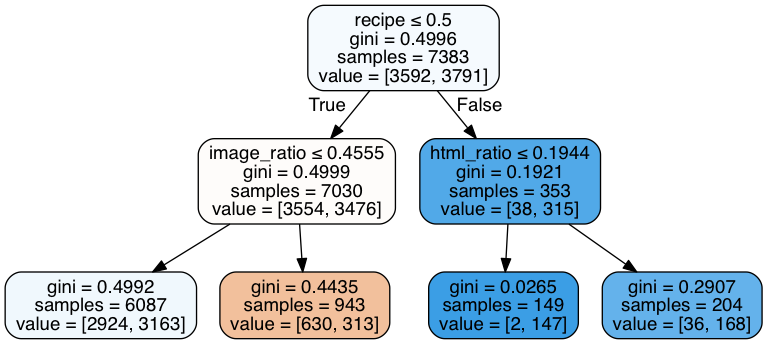

In [16]:
Image(graph.create_png())

In [17]:
model.predict_proba(X[(X['image_ratio']>0.4555) & (X['recipe']==0)])

array([[ 0.66808059,  0.33191941],
       [ 0.66808059,  0.33191941],
       [ 0.66808059,  0.33191941],
       ..., 
       [ 0.66808059,  0.33191941],
       [ 0.66808059,  0.33191941],
       [ 0.66808059,  0.33191941]])

In [18]:
# Use this command to save the decision tree to a pdf file (or other file format)
#graph.write_pdf('file.pdf')

## Decision Trees in scikit-learn

1. In your groups from earlier, work on evaluating the decision tree using cross-validation methods.
2. What metrics would work best?  Why?

**Check:** Are you able to evaluate the decision tree model using cross-validation methods?

In [19]:
from sklearn.model_selection import cross_val_score

model = DecisionTreeClassifier()

X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)
    
    
# Fits the model
model.fit(X, y)

for scoring in ['roc_auc','accuracy','recall','precision']:
    scores = cross_val_score(model, X, y, scoring=scoring, cv=5)
    print scoring, ':'
    print('CV {} {}, Average {} {}'.format(scoring,scores,scoring,scores.mean()))

roc_auc :
CV roc_auc [ 0.53094438  0.53140631  0.54196096  0.53151711  0.56149631], Average roc_auc 0.539465015385
accuracy :
CV accuracy [ 0.54194858  0.53486798  0.55420054  0.53387534  0.56775068], Average accuracy 0.546528622611
recall :
CV recall [ 0.54018445  0.53825858  0.56728232  0.53825858  0.56596306], Average recall 0.549989397242
precision :
CV precision [ 0.54712042  0.54350736  0.5474934   0.54336043  0.57795699], Average precision 0.551887721636


###  Adjusting Decision Trees to Avoid Overfitting

1. You can control for overfitting in decision trees by adjusting one of the following parameters:
  - `max_depth`:  Control the maximum number of questions.
  - `min_samples_in_leaf`:  Control the minimum number of records in each node.

2. Test each of these parameters below.

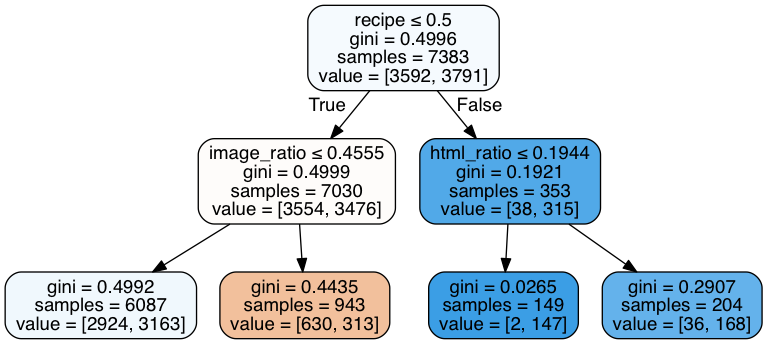

In [20]:
# Control for overfitting in the decision model by adjusting 
# the maximum number of questions (max_depth) or the minimum 
# number of records in each final node (min_samples_leaf)
model = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)

model.fit(X, y)
dot_data = StringIO()
graph = build_tree_image(model,dot_data)
Image(graph.create_png())

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
model = DecisionTreeClassifier()
params = {'max_depth': range(1,11),
          'min_samples_leaf': range(1,11)}
gs = GridSearchCV(model,param_grid=params,scoring='roc_auc',cv=5)
gs.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [23]:
print gs.best_score_
print gs.best_params_

0.611866559481
{'max_depth': 6, 'min_samples_leaf': 4}


## Activity: Classification with decision trees & random forests
 
### Demo: Build a random forest model to predict the evergreeness of a website. 

In [24]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20)
    
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Demo: Extracting importance of features

In [25]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

,Features,Importance Score
1,html_ratio,0.527118
0,image_ratio,0.444251
2,recipe,0.028631


 ### Exercise: Evaluate the Random Forest model using cross-validation; increase the number of estimators and view how that improves predictive performance.

In [26]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

for n_trees in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_val_score(model, X, y, scoring='roc_auc')
    print('n trees: {}, CV AUC {}, Average AUC {}'.format(n_trees, scores, scores.mean()))

CV AUC [ 0.56897176  0.5895828   0.5777541 ], Average AUC 0.57876955296
n trees: 1, CV AUC [ 0.51918017  0.53055536  0.52969915], Average AUC 0.526478226628
n trees: 11, CV AUC [ 0.56405685  0.58644039  0.57535367], Average AUC 0.57528363597
n trees: 21, CV AUC [ 0.56287345  0.58975597  0.58035925], Average AUC 0.5776628892
n trees: 31, CV AUC [ 0.57306382  0.58360729  0.57915407], Average AUC 0.578608395716
n trees: 41, CV AUC [ 0.56120334  0.59211683  0.57423315], Average AUC 0.575851107213
n trees: 51, CV AUC [ 0.56530498  0.58628011  0.58434057], Average AUC 0.578641886487
n trees: 61, CV AUC [ 0.56710056  0.58492057  0.58549382], Average AUC 0.579171650336
n trees: 71, CV AUC [ 0.56953242  0.58876391  0.58052594], Average AUC 0.579607422337
n trees: 81, CV AUC [ 0.56440091  0.59259931  0.58216669], Average AUC 0.579722303907
n trees: 91, CV AUC [ 0.56754665  0.58837098  0.57942825], Average AUC 0.578448626103


##  Independent Practice: Evaluate Random Forest Using Cross-Validation

1. Continue adding input variables to the model that you think may be relevant
2. For each feature:
  - Evaluate the model for improved predictive performance using cross-validation
  - Evaluate the _importance_ of the feature
  
3. **Bonus**: Just like the 'recipe' feature, add in similar text features and evaluate their performance.


In [27]:
## 1. Building a model with more relevant features

model = RandomForestClassifier(n_estimators=50)

# Continue to add features to X
#     Build dummy features, include quantitative features, or add text features
X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna()

y = X['label']

X.drop('label', axis=1, inplace=True)


## 2a. Evaluate predictive performance for the given feature set
scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

# 3 (BONUS): Adding in text features

# Check for keywords in the title
data['PhotoInTitle'] = data['title'].fillna('').str.lower().str.contains('photo').astype(int)
X = data[['image_ratio', 'html_ratio', 'recipe', 'PhotoInTitle', 'label']].dropna()
X.drop('label', axis=1, inplace=True)


scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))


## 2b. Evaluating feature importances

# Fit a model on the whole dataset
model.fit(X, y)

# Get columns and their scores
features = X.columns
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

CV AUC [ 0.56499823  0.58509605  0.5831387 ], Average AUC 0.577744325489
CV AUC [ 0.56891761  0.59637523  0.58748514], Average AUC 0.584259327085


,Features,Importance Score
1,html_ratio,0.527975
0,image_ratio,0.436458
2,recipe,0.030516
3,PhotoInTitle,0.005051
